### Loading our model

In [1]:
from keras.models import load_model
model = load_model('emotion.h5') #this is VGG16
#model = load_model('emotion.h5') #this is VGG9 (LittleVGG)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




### Video slicing by frame interval

In [10]:
import cv2
import numpy as np
import pandas as pd
from time import sleep
from keras.preprocessing.image import img_to_array
import imageio
import time
from tkinter import filedialog
from tkinter import *
import os
import config as cfg
import emotion as emo

e = emo.emotion
df_data = pd.DataFrame()
df_data2 = pd.DataFrame()

#open file dialog for video file selection
root = Tk()
root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select file",filetypes = (("mp4 files","*.mp4"),("all files","*.*")))
fileNameOnly, ext = os.path.splitext(root.filename)
filepath = os.path.dirname(root.filename)
root.destroy()
#print("filepath: ", filepath)

# creating a new folder name based from selected video file
if not os.path.exists(fileNameOnly): 
    os.makedirs(fileNameOnly) 

    
t0=time.time()
print("Time start: ", time.asctime(time.localtime(t0)))

#read selected video file
reader = imageio.get_reader(root.filename)

#get the fps
#print(reader.get_meta_data())
duration = reader.get_meta_data()["duration"]
print("Video duration: ", duration ," seconds")
fps = reader.get_meta_data()['fps']

#get second interval based on video's duration
sec = e.get_slice_interval(duration)
print("Video slice interval: ", sec)
interval = round(fps)*sec

df2=pd.DataFrame()

print("Video images saved into ",fileNameOnly)
for i, frame in enumerate(reader):
    if (i%interval)==0: #frame interval slicing
        #face detection
        rects, faces, image = e.face_detector(frame)
        if np.sum([faces]) != 0.0: #emotion prediction on face detected
            frame, df_analysis = e.analyse_emotionVGG9(rects, faces, image, model,"V")

            #prepare dataframe for concat, and append
            df_frame = pd.DataFrame({"Framenum":[i]})
            df_data = pd.concat([df_frame, df_analysis], axis=1)
            df_data2 = df_data2.append(df_data, ignore_index = True)

            #write frame image
        name = 'frame' + str(i) + '.jpg'
        imageio.imwrite(fileNameOnly+"/"+name, frame)
        
#save df_analysis to a csv file for future processing
df_data2.to_csv(fileNameOnly + "/" + "emotion_analysis_video.csv", index=False)

t1= time.time()
print("Time end: ", time.asctime(time.localtime(t1)))
print("Completed. Time taken: ", time.strftime("%H:%M:%S", time.gmtime(t1-t0)))

Time start:  Sun Mar 29 16:01:15 2020
Video duration:  53.25  seconds
Video slice interval:  1
Video images saved into  C:/Users/elton/Google Drive/AI Course/Capstone Project SL codes/KSL_202003291338/data/Ravdess_Actor07_M_happy_angry_happy
Time end:  Sun Mar 29 16:01:43 2020
Completed. Time taken:  00:00:27


### Plot the chart for facial analysis

In [11]:
### Plot the chart or facial analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv(fileNameOnly+"/"+"emotion_analysis_video.csv")
#data = pd.read_csv("C:/Users/X270/Desktop/Project/data/Ravdess_Version2/emotion_analysis_video.csv")
data.head(10)

,Framenum,Predictions,Pred_Mapping,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
0,0,Happy,1,0.043317,0.066265,0.014863,0.827401,0.013035,0.007852,0.027266
1,30,Happy,1,0.028459,0.049694,0.004642,0.895517,0.008262,0.002148,0.011278
2,60,Disgust,-1,0.266851,0.439525,0.042469,0.191187,0.011913,0.023607,0.024446
3,90,Happy,1,0.091451,0.175339,0.024258,0.645390,0.015550,0.014885,0.033127
4,120,Happy,1,0.059921,0.111777,0.023037,0.737203,0.017369,0.020668,0.030025
5,150,Disgust,-1,0.308767,0.518459,0.044054,0.030060,0.013960,0.071093,0.013607
6,180,Disgust,-1,0.367715,0.545103,0.033382,0.018938,0.004974,0.021407,0.008482
7,210,Angry,-4,0.469378,0.331981,0.112575,0.013209,0.005434,0.043647,0.023776
8,240,Disgust,-1,0.278185,0.541246,0.039128,0.047771,0.015397,0.063324,0.014948
9,270,Disgust,-1,0.223001,0.461509,0.042994,0.181340,0.017833,0.048525,0.024798


Completed. Time taken:  00:00:15


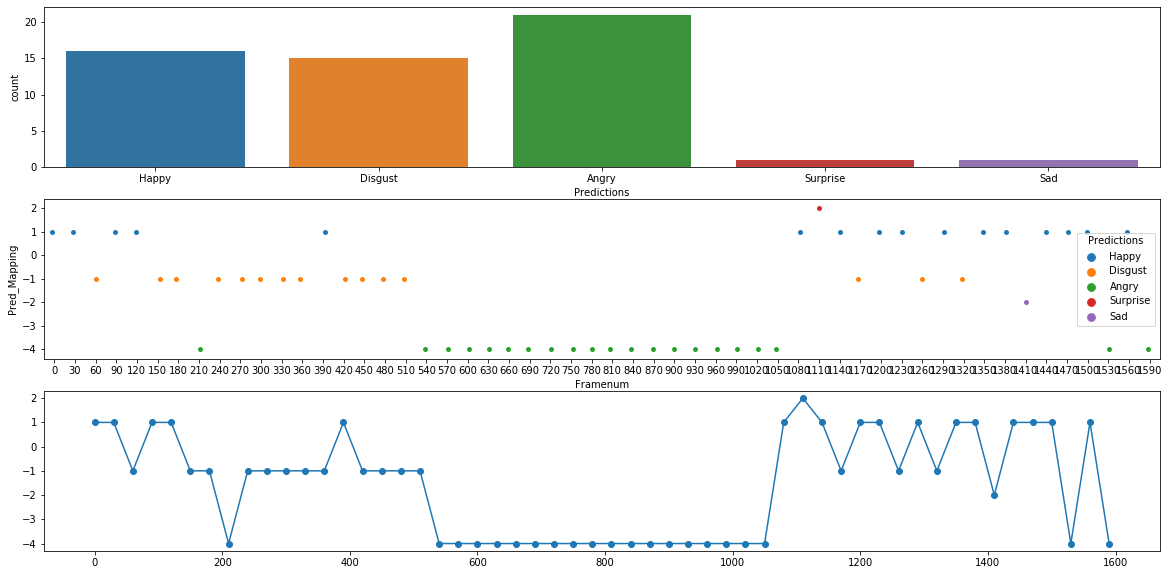

In [12]:
t0=time.time()

fig,(ax1,ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(20,10)

#sns.countplot(y="Predictions", data=data, color="c", ax=ax1)
sns.countplot(x="Predictions", data=data, ax=ax1) #color="c", 
sns.stripplot(x="Framenum", y="Pred_Mapping", data=data, hue="Predictions", ax=ax2)
#sns.boxplot(x="Framenum", y="Predictions", hue="Predictions", data=data, ax=ax2)
#sns.jointplot(x="Framenum", y="Predictions_num", data=data, kind="scatter", color="#4CB391", ax=ax2)

plt.plot("Framenum", "Pred_Mapping", data=data, marker='o')#, color='mediumvioletred')

t1=time.time()
print("Completed. Time taken: ", time.strftime("%H:%M:%S", time.gmtime(t1-t0)))

### Emotion Analysis

In [13]:
map=cfg.pos_neg_mapping

#spilt dataframe into 3 section
df_1st_slice = data[:round(len(data)/3)-1]
df_2nd_slice = data[round(len(data)/3):round(len(data)/3)*2-1]
df_3rd_slice = data[round(len(data)/3)*2:]
df_last5_slice = data[-5:]

print("Video duration:", duration, "seconds")
print("Video analysis taken in interval of:", sec, "second(s)")
print("There are", len(data), "data points analysed.")

#print("Most of the time, subject is feeling", data.Predictions.value_counts().index[0],".\n")#, data.Predictions.value_counts().index.tolist()[1:])
count=0
text=""
for i in data.Predictions.value_counts().index.tolist()[:3]:
    #print(data.Predictions.value_counts().index[count]," (%1.2f%%" %data.Predictions.value_counts(1)[count],")")
    text = text + str(data.Predictions.value_counts().index[count]) + " (%1.2f%%" %data.Predictions.value_counts(1)[count] + ")"
    if count!=2:
        text = text + ", "
    count+=1

print("\nThe top 3 emotions exhibited by the subject in descending order are:", text)

minimum = data.Pred_Mapping.min()
maximum = data.Pred_Mapping.max()

if minimum!=maximum:#there is a min and a max, thus fluatation = True
    if minimum>=0:#fluctation within the positive range
        print("Subject appears to be in a postive emotion range.")
    #check if there is any negative (we call neg extreme emotion fluctation)
    elif minimum<0:#fluctation from positive to negative range
        print("\nIt appears that the subject is not emotionally stable.")
#         print("There is fluctuation between", list(map.keys())[list(map.values()).index(data.Pred_Mapping.max())],"(", 
#           data.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(data.Pred_Mapping.min())],"(",data.Pred_Mapping.min(), ").")
#         print("Occurence of", list(map.keys())[list(map.values()).index(data.Pred_Mapping.min())],"at the following frame number:")        
        
#         #query for the lowest neg emotion
#         df_min = data.query("Pred_Mapping=="+ str(minimum))

#         counter=0
#         text=""
#         while counter < len(df_min):
#             #print(df_min.Framenum.iloc[counter])
#             text= text + str(df_min.Framenum.iloc[counter]) 
#             counter+=1
#             if counter != len(df_min):#not at the last item, then append comma ","
#                 text = text +","
    
#         print(text)
        
        #1st section analysis - 
        minimum_1st_third = df_1st_slice.Pred_Mapping.min()
        maximum_1st_third = df_1st_slice.Pred_Mapping.max()
        if minimum_1st_third!=maximum_1st_third: #there is a min and a max, thus fluatation = True
            if minimum_1st_third < 0: #fluctation from positive to negative range
                print("In the 1st-thirds of the video, subject exhibited emotions of ", list(map.keys())[list(map.values()).index(df_1st_slice.Pred_Mapping.max())],"(", 
          df_1st_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_1st_slice.Pred_Mapping.min())],"(",df_1st_slice.Pred_Mapping.min(), ").")
        
        #2nd section analysis - 
        minimum_2nd_third = df_2nd_slice.Pred_Mapping.min()
        maximum_2nd_third = df_2nd_slice.Pred_Mapping.max()
        if minimum_2nd_third!=maximum_2nd_third: #there is a min and a max, thus fluatation = True
            if minimum_2nd_third < 0: #fluctation from positive to negative range
                print("In the middle section of the video, subject exhibited emotions of ", list(map.keys())[list(map.values()).index(df_2nd_slice.Pred_Mapping.max())],"(", 
          df_2nd_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_2nd_slice.Pred_Mapping.min())],"(",df_2nd_slice.Pred_Mapping.min(), ").")

        #3rd section analysis - 
        minimum_3rd_third = df_3rd_slice.Pred_Mapping.min()
        maximum_3rd_third = df_3rd_slice.Pred_Mapping.max()
        if minimum_3rd_third!=maximum_3rd_third: #there is a min and a max, thus fluatation = True
            if minimum_3rd_third < 0: #fluctation from positive to negative range
                print("In the last third of the video, subject exhibited emotions of ", list(map.keys())[list(map.values()).index(df_3rd_slice.Pred_Mapping.max())],"(", 
          df_3rd_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_3rd_slice.Pred_Mapping.min())],"(",df_3rd_slice.Pred_Mapping.min(), ").")
                
        #last 5 seconds
        df_last5_slice
        minimum_last5 = df_last5_slice.Pred_Mapping.min()
        maximum_last5 = df_last5_slice.Pred_Mapping.max()
        if minimum_last5!=maximum_last5: #there is a min and a max, thus fluatation = True
            if minimum_last5 >= 0: #fluctation within positive range
                print("It was only towards the end of the session (last 5 seconds) that subject turns emotionally stable, ranging from", list(map.keys())[list(map.values()).index(df_last5_slice.Pred_Mapping.max())],"(", 
          df_last5_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_last5_slice.Pred_Mapping.min())],"(",df_last5_slice.Pred_Mapping.min(), ").")

            if minimum_last5 < 0: #fluctation from positive to negative range
                print("Towards the end of the session (last 5 seconds), subject is still not emotionally stable, ranging from", list(map.keys())[list(map.values()).index(df_last5_slice.Pred_Mapping.max())],"(", 
          df_last5_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_last5_slice.Pred_Mapping.min())],"(",df_last5_slice.Pred_Mapping.min(), ").")
                
    


Video duration: 53.25 seconds
Video analysis taken in interval of: 1 second(s)
There are 54 data points analysed.

The top 3 emotions exhibited by the subject in descending order are: Angry (0.39%), Happy (0.30%), Disgust (0.28%)

It appears that the subject is not emotionally stable.
In the 1st-thirds of the video, subject exhibited emotions of  Happy ( 1 ) and Angry ( -4 ).
In the last third of the video, subject exhibited emotions of  Surprise ( 2 ) and Angry ( -4 ).
Towards the end of the session (last 5 seconds), subject is still not emotionally stable, ranging from Happy ( 1 ) and Angry ( -4 ).


In [6]:
# import config as cfg
# duration=220
# sec=1